### 機器學習：分類 Classification

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, f1_score, classification_report, roc_curve, roc_auc_score
import xgboost as xgb
import pickle

pd.set_option('display.max_columns', None)

### 讀入 Dataset

In [2]:
col_to_pick = ['airline',
               'airport_depa',
               'airport_dest',
               'month_actu_depa',
               'day_actu_depa',
               'hr_actu_depa',
               'min_actu_depa',
               'month_actu_dest',
               'day_actu_dest',
               'hr_actu_dest',
               'min_actu_dest',
               'sche_duration',
               'dry_bulb_temp_dest',
               'wet_bulb_temp_dest',
               'dew_point_temp_dest',
               'precipitation_dest',
               'snow_fall_dest',
               'snow_depth_dest',
               'relative_humidity_dest',
               'wind_speed_dest',
               'pressure_dest',
               'visibility_dest',
               'delay_dest']

In [3]:
df = pd.read_csv('../data_write/US_1722_flights_dataset_v1_IQR_ML.csv', usecols=col_to_pick)
df.shape

(28926859, 23)

### 欄位編碼、處理

In [4]:
# # 對 delay_dest_01 進行分類編碼(0, 1)
# df['delay_dest_01'] = np.where((df['delay_dest'] > 5), 1, 0)

In [5]:
# # 挑選流量前 20 大的機場，進行頻率編碼
# airport_to_pick = ['ALT', 'ORD', 'DFW', 'DEN', 'LAX', 'CLI', 'PHX', 'SEA', 'LAS', 'IAN', 'SFO', 'MSP', 'MCO', 'DTW', 'SLC', 'BOS', 'LGA', 'EWR', 'DCA', 'JFK']
# df = df[(df['airport_depa'].isin(airport_to_pick)) & (df['airport_dest'].isin(airport_to_pick))]

freq = df['airline'].value_counts(normalize=True)
df['airline_freq'] = df['airline'].map(freq)
freq = df['airport_depa'].value_counts(normalize=True)
df['airport_depa_freq'] = df['airport_depa'].map(freq)
freq = df['airport_dest'].value_counts(normalize=True)
df['airport_dest_freq'] = df['airport_dest'].map(freq)


# 降雪與否
df['snow'] = np.where((df['snow_fall_dest'] > 0), 1, 0)

# 分鐘數轉整數
df['sche_duration'] = df['sche_duration'].astype(int)

# 壓力轉小數點後2位
df['pressure_dest'] = df['pressure_dest'].round(2)

# 風速轉整數
df['wind_speed_dest'] = df['wind_speed_dest'].astype(int)

# 能見度轉整數
df['visibility_dest'] = df['visibility_dest'].astype(int)

df

,airline,airport_depa,airport_dest,month_actu_depa,day_actu_depa,hr_actu_depa,min_actu_depa,month_actu_dest,day_actu_dest,hr_actu_dest,min_actu_dest,sche_duration,delay_dest,dry_bulb_temp_dest,wet_bulb_temp_dest,dew_point_temp_dest,precipitation_dest,snow_fall_dest,snow_depth_dest,relative_humidity_dest,wind_speed_dest,pressure_dest,visibility_dest,airline_freq,airport_depa_freq,airport_dest_freq,snow
0,DL,ABE,ATL,1,9,6,1,1,9,7,59,136,-17.0,30.0,25.00,13.00,0.000,0.0,0.0,49.00,17,29.56,10,0.146814,0.000607,0.057873,0
1,DL,ABE,ATL,1,10,5,57,1,10,8,16,136,0.0,33.0,29.00,22.00,0.000,0.0,0.0,64.00,20,29.37,10,0.146814,0.000607,0.057873,0
2,DL,ABE,ATL,1,11,5,57,1,11,8,6,136,-10.0,56.0,51.00,46.00,0.000,0.0,0.0,70.00,23,29.22,10,0.146814,0.000607,0.057873,0
3,DL,ABE,ATL,1,12,5,57,1,12,7,56,136,-20.0,54.0,51.00,49.00,0.000,0.0,0.0,83.00,23,29.25,10,0.146814,0.000607,0.057873,0
4,DL,ABE,ATL,1,13,5,54,1,13,7,54,136,-22.0,59.0,58.00,57.00,0.000,0.0,0.0,93.00,23,29.37,10,0.146814,0.000607,0.057873,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28926854,YV,YUM,PHX,12,27,19,7,12,27,20,7,55,-7.0,65.0,52.00,39.00,0.000,0.0,0.0,39.00,17,28.68,10,0.021004,0.000273,0.025462,0
28926855,YV,YUM,PHX,12,28,11,50,12,28,12,49,55,14.0,53.5,52.25,51.25,0.015,0.0,0.0,92.25,17,28.69,3,0.021004,0.000273,0.025462,0
28926856,YV,YUM,PHX,12,29,11,39,12,29,12,25,55,-10.0,60.0,53.00,46.00,0.000,0.0,0.0,60.00,17,28.77,10,0.021004,0.000273,0.025462,0
28926857,YV,YUM,PHX,12,30,11,40,12,30,12,44,55,9.0,56.0,53.50,51.50,0.020,0.0,0.0,85.50,17,28.89,6,0.021004,0.000273,0.025462,0


In [6]:
# 取得頻率編碼表
df_airline = df[['airline', 'airline_freq']]
df_airline = df_airline.drop_duplicates(subset=['airline_freq'], keep='first')
df_airline = df_airline.sort_values(by='airline_freq').reset_index(drop=True)
airline_freq = {k:v for k, v in zip(df_airline.iloc[:, 0], df_airline.iloc[:, 1])}

df_airport_depa = df[['airport_depa', 'airport_depa_freq']]
df_airport_depa = df_airport_depa.drop_duplicates(subset=['airport_depa_freq'], keep='first')
df_airport_depa = df_airport_depa.sort_values(by='airport_depa_freq').reset_index(drop=True)
airport_depa_freq = {k:v for k, v in zip(df_airport_depa.iloc[:, 0], df_airport_depa.iloc[:, 1])}

df_airport_dest = df[['airport_dest', 'airport_dest_freq']]
df_airport_dest = df_airport_dest.drop_duplicates(subset=['airport_dest_freq'], keep='first')
df_airport_dest = df_airport_dest.sort_values(by='airport_dest_freq').reset_index(drop=True)
airport_dest_freq = {k:v for k, v in zip(df_airport_dest.iloc[:, 0], df_airport_dest.iloc[:, 1])}

# # 將字典轉換為JSON格式並保存到文件中
# with open('../json/airline_freq.json', 'w') as i:
#     json.dump(airline_freq, i)
# with open('../json/airport_depa_freq.json', 'w') as j:
#     json.dump(airport_depa_freq, j)
# with open('../json/airport_dest_freq.json', 'w') as k:
#     json.dump(airport_dest_freq, k)

### 欄位切割

In [7]:
# # 計算 delay 的資料量
# df['delay_dest'].value_counts()

將有 delay 的資料切割出來

In [8]:
# # 切割 delay 資料
# df_delay = df[df['delay_dest'] > 5]
# df_delay.shape

In [9]:
# # 切割 未delay 資料
# df_ontime = df[df['delay_dest'] <= 5]
# df_ontime.shape

In [10]:
# # 亂數取 未 delay 的 index
# random_index = np.random.randint(low=0 ,high=len(df_ontime), size=len(df_delay))
# random_index = random_index.tolist()

# # 建立以亂數篩選後筆數與 delay 資料相同的 未delay 資料
# df_ontime_random = df_ontime.iloc[random_index, :]
# df_ontime_random.shape

In [11]:
# # 合併資料量相同的 delay 與 未delay 資料
# df_ML = pd.concat([df_delay, df_ontime_random], axis=0, ignore_index=True)
# df_ML.shape

### 設定 X, y

In [12]:
# 設定 X, y
y = df['delay_dest']
cols = ['airline_freq',
        'airport_depa_freq',
        'airport_dest_freq',
        'month_actu_depa',
        'day_actu_depa',
        'hr_actu_depa',
        'min_actu_depa',
        'month_actu_dest',
        'day_actu_dest',
        'hr_actu_dest',
        'min_actu_dest',
        'sche_duration',
        'dry_bulb_temp_dest',
        # 'wet_bulb_temp_dest',
        # 'dew_point_temp_dest',
        'precipitation_dest',
        'snow_fall_dest',
        # 'snow_depth_dest',
        'relative_humidity_dest',
        'wind_speed_dest',
        'pressure_dest',
        'visibility_dest'
        ]
X = df[cols]

In [13]:
X

,airline_freq,airport_depa_freq,airport_dest_freq,month_actu_depa,day_actu_depa,hr_actu_depa,min_actu_depa,month_actu_dest,day_actu_dest,hr_actu_dest,min_actu_dest,sche_duration,dry_bulb_temp_dest,precipitation_dest,snow_fall_dest,relative_humidity_dest,wind_speed_dest,pressure_dest,visibility_dest
0,0.146814,0.000607,0.057873,1,9,6,1,1,9,7,59,136,30.0,0.000,0.0,49.00,17,29.56,10
1,0.146814,0.000607,0.057873,1,10,5,57,1,10,8,16,136,33.0,0.000,0.0,64.00,20,29.37,10
2,0.146814,0.000607,0.057873,1,11,5,57,1,11,8,6,136,56.0,0.000,0.0,70.00,23,29.22,10
3,0.146814,0.000607,0.057873,1,12,5,57,1,12,7,56,136,54.0,0.000,0.0,83.00,23,29.25,10
4,0.146814,0.000607,0.057873,1,13,5,54,1,13,7,54,136,59.0,0.000,0.0,93.00,23,29.37,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28926854,0.021004,0.000273,0.025462,12,27,19,7,12,27,20,7,55,65.0,0.000,0.0,39.00,17,28.68,10
28926855,0.021004,0.000273,0.025462,12,28,11,50,12,28,12,49,55,53.5,0.015,0.0,92.25,17,28.69,3
28926856,0.021004,0.000273,0.025462,12,29,11,39,12,29,12,25,55,60.0,0.000,0.0,60.00,17,28.77,10
28926857,0.021004,0.000273,0.025462,12,30,11,40,12,30,12,44,55,56.0,0.020,0.0,85.50,17,28.89,6


### 熱力圖

In [14]:
# heatmap_cols = ['delay_dest',
#                 'airline_freq',
#                 'airport_depa_freq',
#                 'airport_dest_freq',
# #                 'month_actu_depa',
# #                 'day_actu_depa',
#                 'hr_actu_depa',
#                 'min_actu_depa',
# #                 'month_actu_dest',
# #                 'day_actu_dest',
#                 'hr_actu_dest',
#                 'min_actu_dest',
#                 'sche_duration',
#                 'dry_bulb_temp_dest',
#                 'wet_bulb_temp_dest',
#                 'dew_point_temp_dest',
#                 'precipitation_dest',
#                 'snow_fall_dest',
#                 'snow_depth_dest',
#                 'relative_humidity_dest',
#                 'wind_speed_dest',
#                 'pressure_dest',
#                 'visibility_dest'
#                 ]

In [15]:
# import seaborn as sns

# # 建立新繪圖區、設定畫布大小
# plt.figure(figsize=(15, 15))

# # 繪製熱力圖
# sns.heatmap(df[heatmap_cols].corr(),
#             annot=True,
#             fmt=".3f",
#             linewidth=.5,
#             cmap="RdBu",
#             center=0,
#             square=True)

# # 標題
# plt.title('heatmap')

# # 顯示圖表
# plt.show()

### XGboost

[0]	validation_0-rmse:15.33787	validation_1-rmse:15.34264
[1]	validation_0-rmse:15.10754	validation_1-rmse:15.11217
[2]	validation_0-rmse:14.89466	validation_1-rmse:14.89919
[3]	validation_0-rmse:14.70103	validation_1-rmse:14.70544
[4]	validation_0-rmse:14.52235	validation_1-rmse:14.52664
[5]	validation_0-rmse:14.35810	validation_1-rmse:14.36230
[6]	validation_0-rmse:14.20957	validation_1-rmse:14.21363
[7]	validation_0-rmse:14.07227	validation_1-rmse:14.07626
[8]	validation_0-rmse:13.94719	validation_1-rmse:13.95110
[9]	validation_0-rmse:13.83288	validation_1-rmse:13.83669
[10]	validation_0-rmse:13.72929	validation_1-rmse:13.73303
[11]	validation_0-rmse:13.63464	validation_1-rmse:13.63827
[12]	validation_0-rmse:13.54794	validation_1-rmse:13.55148
[13]	validation_0-rmse:13.46884	validation_1-rmse:13.47231
[14]	validation_0-rmse:13.39717	validation_1-rmse:13.40057
[15]	validation_0-rmse:13.33146	validation_1-rmse:13.33479
[16]	validation_0-rmse:13.27077	validation_1-rmse:13.27398
[17]	va

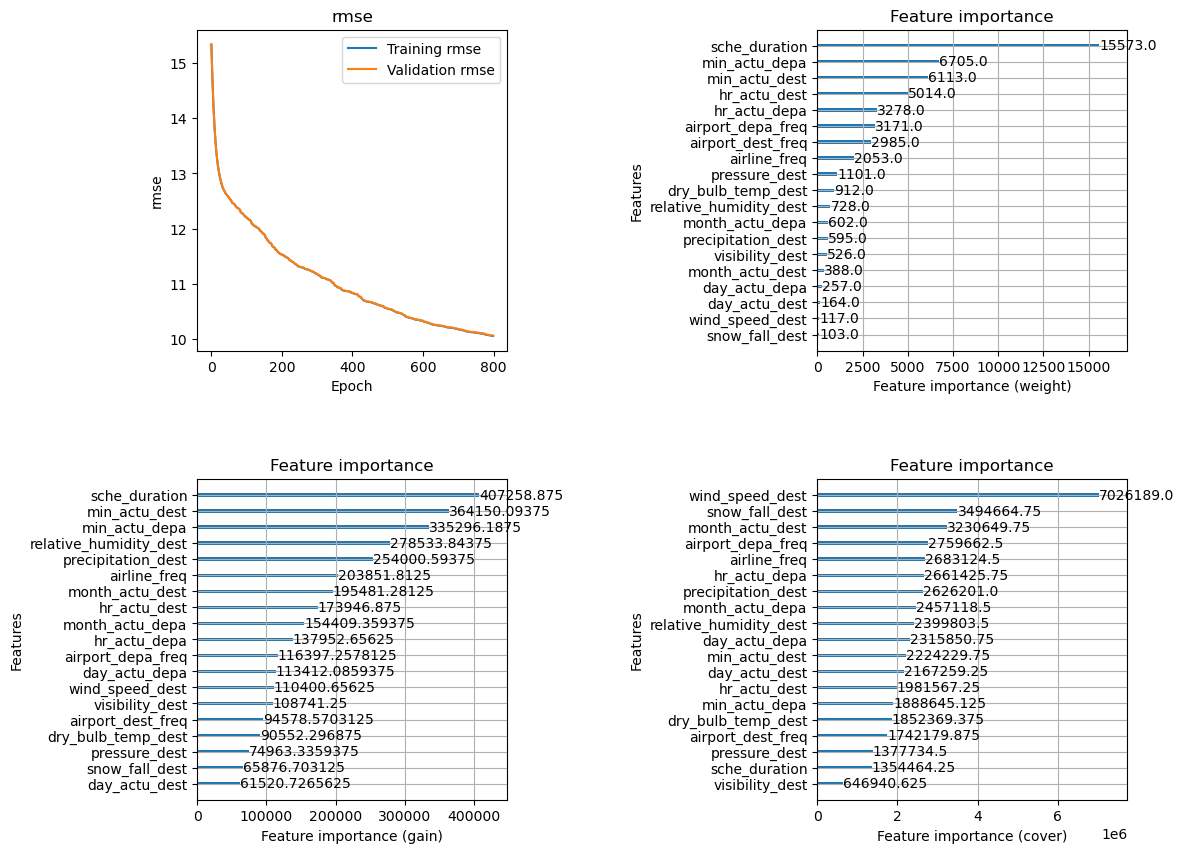

In [18]:
# 切割 train, test, validation 資料
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=36)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=76)


# # 標準化
# scaler = preprocessing.StandardScaler().fit(X_train)
# X_train = scaler.transform(X_train)
# X_val = scaler.transform(X_val)
# X_test = scaler.transform(X_test)


# 設定 XGBoost 參數
params = {
    'n_estimators': 800,
    'learning_rate': 0.05,
    # 'max_depth': 8,             # 'max_depth' & 'max_leaves'擇一
    # 'max_leaves': 30,            # 'max_depth' & 'max_leaves'擇一
    # 'reg_alpha': 0.3,             # 取值在 0 到 1 之間
    # 'reg_lambda': 0.3,            # 取值在 0 到 1 之間
    'random_state': 66,
    'early_stopping_rounds': 10,
    'eval_metric': 'rmse'      # 評估指標：'logloss'（對數損失）、'auc'（曲線下面積）、'error'（分類錯誤率）
}


# 訓練模型並紀錄損失
regressor = xgb.XGBRegressor(**params)
eval_set = [(X_train, y_train), (X_val, y_val)]
regressor.fit(X_train, y_train, eval_set=eval_set, verbose=True)
train_auc = regressor.evals_result()['validation_0']['rmse']
val_auc = regressor.evals_result()['validation_1']['rmse']


# 預測結果
y_test_pred = regressor.predict(X_test)
# 衡量模型指標
mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
print(f'mse: {mse}')
print(f'r2: {r2}')

# 繪製損失曲線圖表、特徵重要性圖表'weight'、'gain'和'cover'
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
# 繪製損失曲線圖表
ax[0, 0].plot(train_auc, label='Training rmse')
ax[0, 0].plot(val_auc, label='Validation rmse')
ax[0, 0].set_xlabel('Epoch')
ax[0, 0].set_ylabel('rmse')
ax[0, 0].set_title('rmse')
ax[0, 0].legend()
# 繪製特徵重要性圖表
xgb.plot_importance(regressor, ax=ax[0, 1], xlabel='Feature importance (weight)', importance_type='weight')
xgb.plot_importance(regressor, ax=ax[1, 0], xlabel='Feature importance (gain)', importance_type='gain')
xgb.plot_importance(regressor, ax=ax[1, 1], xlabel='Feature importance (cover)', importance_type='cover')
# 調整子圖之間的間距
plt.subplots_adjust(wspace=1, hspace=0.4)
plt.show()

In [ ]:
# # 預測測試集樣本的概率
# y_proba = classifier.predict_proba(X_test)[:, 1]

# # 計算FPR、TPR和閾值
# fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# # 繪製ROC曲線
# plt.plot(fpr, tpr, label='ROC curve')
# plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.legend()
# plt.show()

# # 計算AUC
# auc = roc_auc_score(y_test, y_proba)
# print('AUC: %.2f' % auc)

In [ ]:
# # 0為未delay、1為delay
# # 輸出模型準確率、召回率、F1score
# print(classification_report(y_test, y_test_pred))

### 儲存模型

In [ ]:
# pickle.dump(regressor, open("../model/xgb_regression_0424_16000_0.005.pkl", "wb"))